In [7]:
import os
import numpy as np
import damask

# 1. input files (geometery, material, load)

## geometry file

Uses the -g flag in simulations.

Stores information about the sample, e.g. “my material dimensions are 2µm x 2µm x 2µm, and we subdivide it into a grid of 10 x 10 x 10”

In [39]:
help(damask.GeomGrid.from_Voronoi_tessellation)

Help on function from_Voronoi_tessellation in module damask._geomgrid:

from_Voronoi_tessellation(cells: Union[numpy.ndarray, Sequence[int]], size: Union[numpy.ndarray, Sequence[float]], seeds: numpy.ndarray, material: Union[numpy.ndarray, Sequence[int], NoneType] = None, periodic: bool = True) -> 'GeomGrid'
    Create grid from Voronoi tessellation.
    
    Parameters
    ----------
    cells : sequence of int, len (3)
        Cell counts along x,y,z direction.
    size : sequence of float, len (3)
        Edge lengths of the grid in meter.
    seeds : numpy.ndarray of float, shape (:,3)
        Position of the seed points in meter. All points need
        to lay within the box [(0,0,0),size].
    material : sequence of int, len (seeds.shape[0]), optional
        Material ID of the seeds.
        Defaults to None, in which case materials are consecutively numbered.
    periodic : bool, optional
        Assume grid to be periodic. Defaults to True.
    
    Returns
    -------
    new

In [10]:
# geometry file (3d periodic grid)
size = np.ones(3)*1e-5
cells = [4,4,4]
N_grains = 4
seeds = damask.seeds.from_random(size,N_grains,cells)
grid = damask.GeomGrid.from_Voronoi_tessellation(cells,size,seeds)
grid

cells:  4 × 4 × 4
size:   1e-05 × 1e-05 × 1e-05 m³
origin: 0.0   0.0   0.0 m
# materials: 4

In [52]:
grid.save(f'Polycrystal_{N_grains}_{cells[0]}x{cells[1]}x{cells[2]}')

## material file


-m: material and property definition, e.g. “I use pure aluminium with these plasticity and elasticity properties”

In [29]:
mat = damask.ConfigMaterial()

In [30]:
hom_single = {
    'SX': {                            # (1) name of homogenization, SX->single crystal
        'N_constituents': 1,           # (2) components number
        'mechanical': {'type': 'pass'} # (3) type of homogenization
    }
}

mat.update(homogenization=hom_single) # add to material.yaml file

We can look at the example files from the DAMASK repository and adopt the parameters we want:

`DAMASK/examples/config/phase/mechanical/elastic/Hooke_Al.yaml`

`DAMASK/examples/config/phase/mechanical/plastic/phenopowerlaw_Al.yaml`

In [55]:
phase_alu = {
    'Aluminium':{                                    # (1) name of your phase
        'lattice': 'cF',                             # (2) lattice specific
        'mechanical': {                              # (3) mechanical properties
            'output': ['F', 'P', 'F_e', 'L_p', 'O'], # Your desired output quantities
            'elastic': {
              'type': 'Hooke',
              'C_11': 106.9e+9,
              'C_12': 60.5e+9,
              'C_44': 28.4e+9,
              },
            'plastic': {
                'type': 'phenopowerlaw',
                'output': ['xi_sl', 'gamma_sl'],
                'N_sl': [12],
                'dot_gamma_0_sl': [7.5e-05],
                'n_sl': [20],
                'a_sl': [5.4],
                'xi_0_sl': [2690000.0],
                'xi_inf_sl': [67500000.0],
                'h_0_sl-sl': [281500000.0],
                'h_sl-sl': [1, 1, 5.123, 0.574, 1.123, 1.123, 1]
            }
        }
    }
}

In [56]:
mat.update(phase=phase_alu) # add to material.yaml file

In [57]:
mat

homogenization:
  SX:
    N_constituents: 1
    mechanical: {type: pass}
phase:
  Aluminium:
    lattice: cF
    mechanical:
      output: [F, P, F_e, L_p, O]
      elastic: {type: Hooke, C_11: 106900000000.0, C_12: 60500000000.0, C_44: 28400000000.0}
      plastic:
        type: phenopowerlaw
        output: [xi_sl, gamma_sl]
        N_sl: [12]
        dot_gamma_0_sl: [7.5e-05]
        n_sl: [20]
        a_sl: [5.4]
        xi_0_sl: [2690000.0]
        xi_inf_sl: [67500000.0]
        h_0_sl-sl: [281500000.0]
        h_sl-sl: [1, 1, 5.123, 0.574, 1.123, 1.123, 1]
material:
- constituents:
  - phase: Aluminium
    O: [0.19162283628804802, 0.7634102184674582, -0.5615127566481481, 0.25532127031210955]
    v: 1.0
  homogenization: SX
- constituents:
  - phase: Aluminium
    O: [0.029784985070057828, -0.4496898179946728, 0.28964359906152315, -0.844392389697457]
    v: 1.0
  homogenization: SX
- constituents:
  - phase: Aluminium
    O: [0.2943812648506575, 0.8471371850251173, -0.07392957705

Generate random orientations for each grain

In [41]:
rnd = damask.Rotation.from_random(N_grains)
rnd

Quaternions of shape (4,)
[[ 0.1936324   0.79727297 -0.31331187 -0.47822377]
 [ 0.26727619 -0.44849241  0.02724348  0.85245281]
 [ 0.50514239  0.03858115 -0.79430186  0.33530167]
 [ 0.8561308   0.18642792 -0.06283801 -0.47784524]]

In [35]:
mat = mat.material_add(O=rnd,phase='Aluminium',homogenization='SX')
mat

homogenization:
  SX:
    N_constituents: 1
    mechanical: {type: pass}
phase:
  Aluminium:
    lattice: cF
    mechanical:
      output: [F, P, F_e, L_p, O]
      elastic: {C_11: 106900000000.0, C_12: 60500000000.0, C_44: 28400000000.0}
      plastic:
        type: phenopowerlaw
        output: [xi_sl, gamma_sl]
        N_sl: [12]
        dot_gamma_0_sl: [7.5e-05]
        n_sl: [20]
        a_sl: [5.4]
        xi_0_sl: [2690000.0]
        xi_inf_sl: [67500000.0]
        h_0_sl-sl: [281500000.0]
        h_sl-sl: [1, 1, 5.123, 0.574, 1.123, 1.123, 1]
material:
- constituents:
  - phase: Aluminium
    O: [0.19162283628804802, 0.7634102184674582, -0.5615127566481481, 0.25532127031210955]
    v: 1.0
  homogenization: SX
- constituents:
  - phase: Aluminium
    O: [0.029784985070057828, -0.4496898179946728, 0.28964359906152315, -0.844392389697457]
    v: 1.0
  homogenization: SX
- constituents:
  - phase: Aluminium
    O: [0.2943812648506575, 0.8471371850251173, -0.0739295770589181, -0.436

In [58]:
mat.save('material.yaml')

## load file

-l: loadfile: definition of load, e.g. “my material is put under tension along axis X, with 10e+5 Pa, for 5 seconds, at 300C°”

We define dot_F (rate of change of deformation) and the corresponding P

In [45]:
dot_F = [[1.e-3, 0 , 0 ],
         [   0 ,'x', 0 ],
         [   0 , 0 ,'x']]

P = [['x', 'x', 'x'],
     ['x',   0, 'x'],
     ['x', 'x',   0]]

In [50]:
load_config = damask.LoadcaseGrid(
    solver={'mechanical':'spectral_basic'}, # (1) solver specification,
    loadstep=[
        {
            # (2) Boundary Conditions, what kind of force is applied?
            'boundary_conditions':{
                'mechanical':{
                    'dot_F': dot_F, # specified degree of change of deformation, alternatively specify F or L
                    'P': P
                }
            },
            # (3) time discretization, 10 seconds, 40 time increments -> 0.25 seconds per time increment
            'discretization':{'t':10.,'N':40},
            # (4) output frequency
            'f_out':4
        }
    ]
)
load_config

solver: {mechanical: spectral_basic}
loadstep:
- boundary_conditions:
    mechanical:
      dot_F:
      - [0.001, 0, 0]
      - [0, x, 0]
      - [0, 0, x]
      P:
      - [x, x, x]
      - [x, 0, x]
      - [x, x, 0]
  discretization: {t: 10.0, N: 40}
  f_out: 4

In [51]:
load_config.save('load.yaml')

right now you have a similar input file named as 
- `Polycrystal_{N_grains}_{cells}.vti`
- `material.yaml`
- `load.yaml`

in your folder now, which resemble the ones in `ref/`

# 2. run simulation with DAMASK-grid solver

In [59]:
fn_vti = f'Polycrystal_{N_grains}_{cells[0]}x{cells[1]}x{cells[2]}.vti'
fn_load = 'load.yaml'
fn_material = 'material.yaml'

In [60]:
run_log = damask.util.run(f'DAMASK_grid -g {fn_vti} -l {fn_load}  -m {fn_material}')

running 'DAMASK_grid -g Polycrystal_4_4x4x4.vti -l load.yaml  -m material.yaml' in './'


In [61]:
print(''.join(run_log))


 <<<+-  parallelization init  -+>>>

 Open MPI v4.1.2, package: Debian OpenMPI, ident: 4.1.2, repo rev: v4.1.2, Nov 24, 2021
 MPI standard: 3.1
 OpenMP version: 201511

 MPI processes: 1
 Could not get $OMP_NUM_THREADS, using default
 OMP_NUM_THREADS: 4

 <<<+-  CLI init  -+>>>

     _/_/_/      _/_/    _/      _/    _/_/      _/_/_/  _/    _/    _/_/_/
    _/    _/  _/    _/  _/_/  _/_/  _/    _/  _/        _/  _/            _/
   _/    _/  _/_/_/_/  _/  _/  _/  _/_/_/_/    _/_/    _/_/          _/_/
  _/    _/  _/    _/  _/      _/  _/    _/        _/  _/  _/            _/
 _/_/_/    _/    _/  _/      _/  _/    _/  _/_/_/    _/    _/    _/_/_/
 Grid solver

 F. Roters et al., Computational Materials Science 158:420–478, 2019
 https://doi.org/10.1016/j.commatsci.2018.04.030


 Version: v3.0.0

 Compiled with: GCC version 11.4.0
 Compiled on: Linux-5.4.0-189-generic
 Compiler options: -cpp -I /usr/lib/petscdir/petsc3.15/x86_64-linux-gnu-real/include -I /usr/include/hypre -I /usr/inclu

# 3. process result and visualize

## basic post-processing

In [64]:
help(damask.Result)

Help on class Result in module damask._result:

class Result(builtins.object)
 |  Result(fname: Union[str, pathlib.Path])
 |  
 |  Add data to and export data from a DADF5 (DAMASK HDF5) file.
 |  
 |  A DADF5 file contains DAMASK results.
 |  Its group/folder structure reflects the layout in material.yaml.
 |  
 |  This class provides a customizable view on the DADF5 file.
 |  Upon initialization, all attributes are visible.
 |  Derived quantities are added to the file and existing data is
 |  exported based on the current view.
 |  
 |  Examples
 |  --------
 |  Open 'my_file.hdf5', which is assumed to contain deformation gradient 'F'
 |  and first Piola-Kirchhoff stress 'P', add the Mises equivalent of the
 |  Cauchy stress, and export it to VTK (file) and numpy.ndarray (memory).
 |  
 |  >>> import damask
 |  >>> r = damask.Result('my_file.hdf5')
 |  >>> r
 |  \x1bCreated by DAMASK_grid ...
 |          on ...
 |   executing "..."\x1b
 |  ...
 |  
 |  Methods defined here:
 |  
 |  _

In [63]:
fn_hdf = 'Polycrystal_4_4x4x4_load_material.hdf5'
result = damask.Result(fn_hdf)
result

Created by DAMASK_grid v3.0.0
        on 2024-09-25 16:42:49+0200
 executing "DAMASK_grid -g Polycrystal_4_4x4x4.vti -l load.yaml -m material.yaml"

increment_0 (0.0 s)
  phase
    Aluminium
      mechanical
        F / 1: deformation gradient
        F_e / 1: elastic deformation gradient
        L_p / 1/s: plastic velocity gradient
        O / 1: crystal orientation as quaternion q_0 (q_1 q_2 q_3)
        P / Pa: first Piola-Kirchhoff stress
        gamma_sl / 1: plastic shear
        xi_sl / Pa: resistance against plastic slip
  homogenization
    SX
      mechanical

increment_4
  ...

increment_8
  ...

increment_12
  ...

increment_16
  ...

increment_20
  ...

increment_24
  ...

increment_28
  ...

increment_32
  ...

increment_36
  ...

increment_40 (10.0 s)
  phase
    Aluminium
      mechanical
        F / 1: deformation gradient
        F_e / 1: elastic deformation gradient
        L_p / 1/s: plastic velocity gradient
        O / 1: crystal orientation as quaternion q_0 (q_1

In [80]:
help(damask.Result.add_stress_Cauchy)

Help on function add_stress_Cauchy in module damask._result:

add_stress_Cauchy(self, P: str = 'P', F: str = 'F')
    Add Cauchy stress calculated from first Piola-Kirchhoff stress and deformation gradient.
    
    Parameters
    ----------
    P : str, optional
        Name of the dataset containing the first Piola-Kirchhoff stress.
        Defaults to 'P'.
    F : str, optional
        Name of the dataset containing the deformation gradient.
        Defaults to 'F'.



In [65]:
result.add_stress_Cauchy()
result

Created by DAMASK_grid v3.0.0
        on 2024-09-25 16:42:49+0200
 executing "DAMASK_grid -g Polycrystal_4_4x4x4.vti -l load.yaml -m material.yaml"

increment_0 (0.0 s)
  phase
    Aluminium
      mechanical
        F / 1: deformation gradient
        F_e / 1: elastic deformation gradient
        L_p / 1/s: plastic velocity gradient
        O / 1: crystal orientation as quaternion q_0 (q_1 q_2 q_3)
        P / Pa: first Piola-Kirchhoff stress
        gamma_sl / 1: plastic shear
        sigma / Pa: Cauchy stress calculated from P (first Piola-Kirchhoff stress) and F (deformation gradient)
        xi_sl / Pa: resistance against plastic slip
  homogenization
    SX
      mechanical

increment_4
  ...

increment_8
  ...

increment_12
  ...

increment_16
  ...

increment_20
  ...

increment_24
  ...

increment_28
  ...

increment_32
  ...

increment_36
  ...

increment_40 (10.0 s)
  phase
    Aluminium
      mechanical
        F / 1: deformation gradient
        F_e / 1: elastic deformation

In [66]:
result.add_strain()                             # ln(V)
result.add_equivalent_Mises('sigma')            # von Mises value maybe more representative
result.add_equivalent_Mises('epsilon_V^0.0(F)') # von Mises like strain based on ln(V)

Export to ParaView (vtk format)

In [70]:
result.export_VTK()

Export original simulation files from Result object

In [71]:
result.export_simulation_setup(target_dir='sim_setup')

## Plotting simulation results

In [73]:
import pandas as pd
import seaborn as sns

In [74]:
grains = [0,1,3]
grid   = damask.GeomGrid.load(fn_vti) # get back my grid
# loop over all increments and store P(1,1) per grain and avg(F(1,1))
data = {g:pd.DataFrame() for g in grains}
for inc in result.get(['F','P']).values():
    P = inc['P']
    F = inc['F']
    for g in grains:
        points = grid.material.flatten(order='F')==g
        P_11 = P[points,0,0].flatten()
        F_11 = np.broadcast_to(np.average(F[:,0,0]),P_11.shape)
        x = pd.DataFrame({'F_11':F_11,'P_11':P_11})
        data[g] = pd.concat((data[g],x),ignore_index=True)

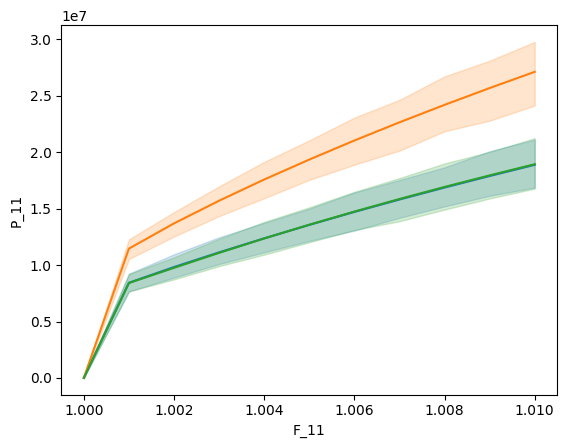

In [75]:
for g in grains:
   plot = sns.lineplot(y='P_11',x='F_11',data=data[g])

fig = plot.get_figure()

## some in-line visualization with pyvista

need to do the following environment setup  (use _virtual environment_ or _conda_ )
- `pip install 'pyvista[jupyter]>=0.38.1'` 
- `pip install ipywidgets 'pyvista[all,trame]'`
- `pip install trame`

_caution! there might be extra lib incompatibility!|_

In [77]:
import pyvista as pv
pv.set_jupyter_backend('trame')

In [78]:
data_grid = pv.read(fn_vti)

pl = pv.Plotter()
pl.add_mesh(data_grid, scalars='material',edge_color='k',show_edges=True)
pl.add_axes()
pl.show()

Widget(value='<iframe src="http://localhost:35123/index.html?ui=P_0x7f2db37d5300_0&reconnect=auto" class="pyvi…

In [81]:
help(damask.Result.view)

Help on function view in module damask._result:

view(self, *, increments: Union[NoneType, int, Sequence[int], str, Sequence[str], bool] = None, times: Union[NoneType, float, Sequence[float], str, Sequence[str], bool] = None, phases: Union[NoneType, str, Sequence[str], bool] = None, homogenizations: Union[NoneType, str, Sequence[str], bool] = None, fields: Union[NoneType, str, Sequence[str], bool] = None, protected: Optional[bool] = None) -> 'Result'
    Set view.
    
    Wildcard matching with '?' and '*' is supported.
    True is equivalent to '*', False is equivalent to [].
    
    Parameters
    ----------
    increments: (list of) int, (list of) str, or bool, optional.
        Numbers of increments to select.
    times: (list of) float, (list of) str, or bool, optional.
        Simulation times of increments to select.
    phases: (list of) str, or bool, optional.
        Names of phases to select.
    homogenizations: (list of) str, or bool, optional.
        Names of homogeniz

In [84]:
rv = result.view(increments=-1)
rv

Created by DAMASK_grid v3.0.0
        on 2024-09-25 16:42:49+0200
 executing "DAMASK_grid -g Polycrystal_4_4x4x4.vti -l load.yaml -m material.yaml"

increment_40 (10.0 s)
  phase
    Aluminium
      mechanical
        F / 1: deformation gradient
        F_e / 1: elastic deformation gradient
        L_p / 1/s: plastic velocity gradient
        O / 1: crystal orientation as quaternion q_0 (q_1 q_2 q_3)
        P / Pa: first Piola-Kirchhoff stress
        epsilon_V^0.0(F) / 1: Seth-Hill strain tensor of order 0.0 based on left stretch tensor of F (deformation gradient)
        epsilon_V^0.0(F)_vM / 1: Mises equivalent strain of epsilon_V^0.0(F) (Seth-Hill strain tensor of order 0.0 based on left stretch tensor of F (deformation gradient))
        gamma_sl / 1: plastic shear
        sigma / Pa: Cauchy stress calculated from P (first Piola-Kirchhoff stress) and F (deformation gradient)
        sigma_vM / Pa: Mises equivalent stress of sigma (Cauchy stress calculated from P (first Piola-Kirc

In [ ]:
rv.export_VTK()

In [83]:
data_last = pv.read('Polycrystal_4_4x4x4_load_material_inc40.vti')

pl = pv.Plotter()
pl.add_mesh(data_last, scalars='phase/mechanical/sigma_vM / Pa', cmap='viridis')
pl.add_axes()
pl.show()

Widget(value='<iframe src="http://localhost:35123/index.html?ui=P_0x7f2d9e5e76d0_1&reconnect=auto" class="pyvi…